## 1. Read Dataframe with Titles and Views Numbers

Now we have a lot of data obtained as a result of web scraping, combined into one large dataset. For reading we use `read_df()` functions and for occasional work with dataset and saving results – `write_df()`.

In [2]:
def write_df(df, filename = 'it_articles_ru'):
    """Write total dataframe with information about all sources"""
    df = df.reset_index() # feather format doesn't work with str indices
    
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # for space economy let's convert types
    df.views_num = df.views_num.astype('Int32')
    for col in ('likes_num', 'favs_num', 'comments_num'):
        df[col] = df[col].astype('Int16')
    
    # zstd compression is best for our str content
    df.to_feather(f'{DATASETS_PATH}/META/{filename}.feather',
                  compression='zstd')
    
    # convert time to simple iso format strings
    df.post_time = df.post_time.apply(lambda x: x.isoformat().replace('+03:00', ''))
    df.parse_time = df.parse_time.apply(lambda x: x.date().isoformat())
    
    print('Main datafame is saved.')
    
df = read_df()

## 3. Target Variable Conversion: Views to Rating

Let's create datasets with the minimum required set of columns, corresponding to the model. We will intentionally code both the title and the summary together, since this is exactly the information that the user sees.

Now we will sort the articles by the number of views and set each position in the top 20% to 1, and for the rest – 0. So the closer the classification score to 1, the more likely the article will receive more views.

It should be noted that we cannot take into consideration articles that were published in the last month, unless they immediately fall into `False` section. Usually, recently published articles have received only few views, but this does not mean that they are not interesting. Often, such articles have simply not been indexed yet.
The same applies to the fact that an article published five years ago has a higher chance of being read more times than one that was published six months ago. To equalize the "chances" of such articles, we divide the timeline into several indipendent segments, where we sort items by the number of views. Hereinafter, the word "time" does not mean an ordinary date, but the difference between the time of publication of the article and the time of parsing.

In [7]:
def Xy_preprocessing(df, true_fraction = 0.5):
    Xy = df[['post_time', 'parse_time', 'title', 'summary', 'views_num']]
    Xy.reset_index(inplace=True)

    # not interested in NA views_num, post_time and parse_time
    Xy.dropna(subset=['views_num', 'parse_time', 'post_time'], inplace=True)

    # drop dupicates of title + summary
    Xy.drop_duplicates(subset=['title', 'summary'],
                       keep='last', inplace=True)

    Xy['delta'] = (Xy['parse_time']-Xy['post_time']).apply(lambda x: int(x.days))
    Xy.drop(columns=['parse_time', 'post_time'], inplace=True)

    # we don't save time of parsing, so delta can be "-1 days" but actually it's 0
    Xy.loc[Xy.delta < 0, 'delta'] = 0

    Xy.sort_values(by='delta', inplace=True)
    Xy.reset_index(drop=True, inplace=True)

    # let's divide the records into blocks that are multiples of 100
    # start block_num is month items length
    block_num = round(Xy.loc[Xy.delta < 30, :].shape[0]/100)*100

    # others bloack are 2**n progression nums
    # -1 used for not making "old tail" too small
    bins_num = round(np.log2(Xy.shape[0]/block_num))-1

    # slices_indexes for bins is cumulative sum for progression
    # this approach makes it possible to consider more modern
    # articles with a higher priority, and treat old ones more strictly.
    bins = np.cumsum([2**n*block_num for n in range(bins_num)])
    bins = np.insert(bins, 0, 0)
    bins = np.append(bins, Xy.shape[0])

    Xy['interval'] = pd.cut(Xy.index, bins,
                            include_lowest=True)

    Xy.sort_values(['interval', 'views_num'],
                   ascending=[True, False],
                   inplace=True)

    Xy.reset_index(drop=True, inplace=True)

    # true fraction is an adjustable value
    arr = (bins + np.diff(bins, append=0)*true_fraction)
    bins = np.ravel([bins, arr],'F')[:-1]

    Xy['target'] = pd.cut(Xy.index, bins,
                               include_lowest=True)

    classes = {interval: 1 if i%2 == 0 else 0 for i, interval in enumerate(Xy.target.unique())}
    Xy.replace({'target': classes}, inplace=True)
    Xy.drop(columns = ['delta', 'interval'], inplace=True)
    
    return Xy

In [8]:
Xy = Xy_preprocessing(df)
#Xy.plot()

In [11]:
Xy[['title', 'views_num', 'target']].to_csv('title_views.csv')

<AxesSubplot:>

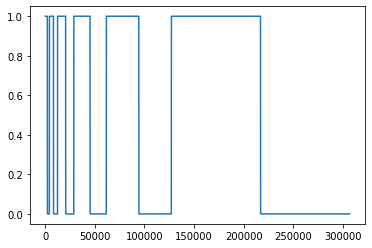

In [10]:
Xy.target.plot()

In [11]:
Xy.to_feather(f'{DATASETS_PATH}/PREPROCESSING/Xy.feather',
              compression='zstd')

<AxesSubplot:>

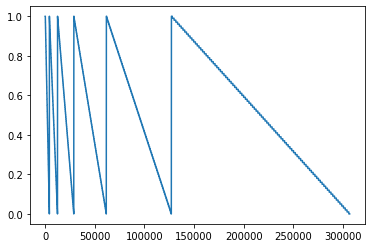

In [65]:
Xy.sample(20000, random_state=0)[['url', 'title']].reset_index(drop=True).to_csv('NER_20k_sample.csv')

In [13]:
num = round(Xy.shape[0]*0.2)

In [14]:
Xy = Xy.sort_values(by='target', ascending=False)

<AxesSubplot:>

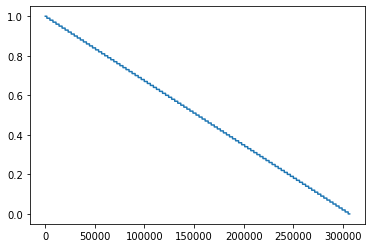

In [15]:
Xy.reset_index().target.plot()

In [18]:
Xy[['title', 'views_num', 'target']].reset_index(drop=True).to_csv('title_views.csv')

In [125]:
df_1 = Xy.iloc[:num, :]

In [126]:
df_0 = Xy.iloc[-num:, :]

In [127]:
df_0 = df_0.drop(columns=['url', 'views_num', 'target']).reset_index(drop=True)
df_1 = df_1.drop(columns=['url', 'views_num', 'target']).reset_index(drop=True)

In [128]:
df_0['target'] = 0
df_1['target'] = 1
df01 = pd.concat([df_0, df_1])

In [130]:
df01

,title,summary,target
0,Пока Sape отдыхает…,Пока sape обновляла ПО и вводила новую систему...,0
1,В Википедии уже 300 000 статей. Всех поздравля...,Количество статей в Русской Википедии перевали...,0
2,Velorama.net,Была у меня идея и желание сделать сервис для ...,0
3,Нужен ли RSS народу?,Всем привет.\nНаверняка если вам понравился ин...,0
4,Реферальная программа — нужен совет,Хотим реализовать реферальную программу для са...,0
...,...,...,...
61385,Как оптимизировать полосу пропускания в сетях ...,В блоге 45 Drives вышел достаточно интересный ...,1
61386,Моя работа на конкурс Mail.Ru,Сегодня в блоге Mail.ru были опубликованы резу...,1
61387,"Обзор Sphero BB-8, робота из «Звёздных войн»","Наверное, с ноября прошлого года все уже успел...",1
61388,Старый код: почему он такой,Большинство из разработчиков рано или поздно с...,1


In [131]:
df01 = df01.sample(frac=1)

In [132]:
df01.reset_index(drop=True, inplace=True)

In [133]:
df01.to_csv('textcat_train_data.csv')

In [134]:
df01

,title,summary,target
0,"Немного подробностей про Class Based Views, ч.3","Приветствую вас вновь, дорогие читатели! Публи...",1
1,Шаблон интерфейса для «умного дома» на Ардуино,Здравствуйте. Целью написания данной статьи яв...,1
2,Жизнь после ICO: как сейчас дела у «Полибиуса»,"5 июля закончилось ICO Polybius, сразу вошедше...",1
3,Роботы-пылесосы iClebo Arte и Neato XV-21 – ср...,Как любитель любого рода автоматизации и автом...,1
4,CSS в AN HTTPD,"AN HTTPD показывает страницу ошибки в случае,\...",0
...,...,...,...
122775,Флибуста заблокирована за «451 градус по Фарен...,"– А вы когда-нибудь читаете книги, которые сжи...",1
122776,«Це невідворотна еволюція суспільства». Чому н...,Український айтішний офшор — до нескінченності...,1
122777,Анти-Сервисный центр Сервисфон,"Хочу предупредить людей, дабы не наткнулись на...",0
122778,Персональные данные и закон,Возникла необходимость прочитать лекцию по «пе...,0
